# Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from src import *
import numpy as np

# Signal

In [3]:
dim = (32,32)

# Sparse signal parameters
sparse_range = (2, 6)
density = 0.005

# Smooth signal parameters
smooth_range = (0, 2)
sigmas_range = (2e-2, 2e-1)
nb_gaussian = 100

# Seed
seed = 42
np.random.seed(seed)

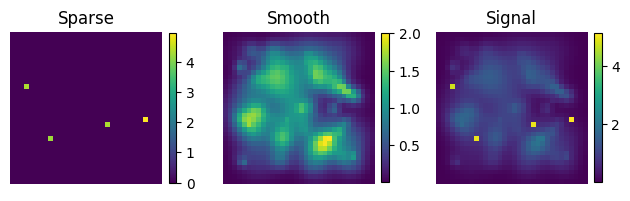

In [4]:
sparse_signal = compute_sparse(dim, sparse_range, density, seed)
smooth_signal = compute_smooth(dim, smooth_range, sigmas_range, nb_gaussian)

signal = sparse_signal + smooth_signal 
plot_signal(sparse_signal,smooth_signal)

# Operator $\phi$

In [5]:
from pyxu.operator import FFT
L = 2.0
theta = 0.5
op = non_uni_FFT(dim,L,theta, on_grid=True)
#op = FFT(dim,real=True)

x0 = signal.reshape(-1)
y0 = op.apply(x0)

pnsr = 50
y = compute_y(y0, pnsr)

# Solver

In [6]:
# Loss weights
lambda1 = 0
lambda2 = 0

x1,x2 = composite_solve(y, op, lambda1, lambda2)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyxu/abc/arithmetic.py:639: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  t2 = float(self._op.apply(self._cst))


INFO -- [2023-10-18 21:14:33.602084] Iteration 0
	iteration: 0
	RelError[x]: 0.0
INFO -- [2023-10-18 21:14:34.007642] Iteration 100
	iteration: 100
	RelError[x]: 0.000666821983111532
INFO -- [2023-10-18 21:14:34.109045] Iteration 125
	iteration: 125
	RelError[x]: 9.173177044977935e-05
INFO -- [2023-10-18 21:14:34.109907] Stopping Criterion satisfied -> END


sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x152317fa0>


0.0027067573520106517 1.0710532759377298e-05


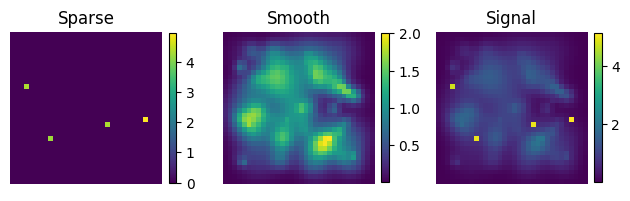

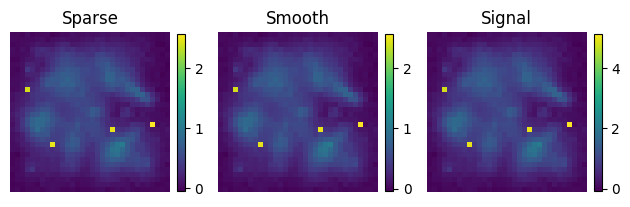

In [7]:
sparse_rcstr, smooth_rcstr, signal_rcstr = map(
    lambda x: x.reshape(dim), (x1, x2, x1 + x2)
)

plot_signal(sparse_signal, smooth_signal)
plot_signal(sparse_rcstr, smooth_rcstr)

print(nmse(signal,signal_rcstr), wasserstein_dist(signal,signal_rcstr))